In [1]:
import tifffile
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw

To showcase the new method, first I generate a DAPI image with the dimensions of the raw data, which I initially used to overlay the H&E and CODEX images

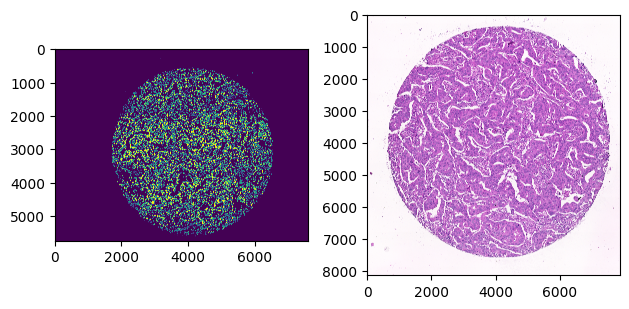

In [2]:
ORIGINAL_CODEX_DIMENSIONS = (7587, 5751)

transform_matrix = np.array([[-0.6974712610244751,  -0.025579674169421196,  7090.890510750511],
                             [-0.02557258866727352,  0.6980617642402649,    407.3607000383897]])

inverse_matrix = cv2.invertAffineTransform(transform_matrix)

he = tifffile.imread(Path("data", "core_YB_b_14_pyramidal", "C00_HE.ome.tiff"))
dapi = tifffile.imread(Path("data", "core_YB_b_14_pyramidal", "masks", "C01_DAPI_1.ome.tiff"))

dapi_raw_data = cv2.warpAffine(dapi, transform_matrix, ORIGINAL_CODEX_DIMENSIONS)

plt.subplot(1, 2, 1)
plt.imshow(dapi_raw_data)

plt.subplot(1, 2, 2)
plt.imshow(he)

plt.tight_layout()

Here is how the old affine transform overlays the 2 regions

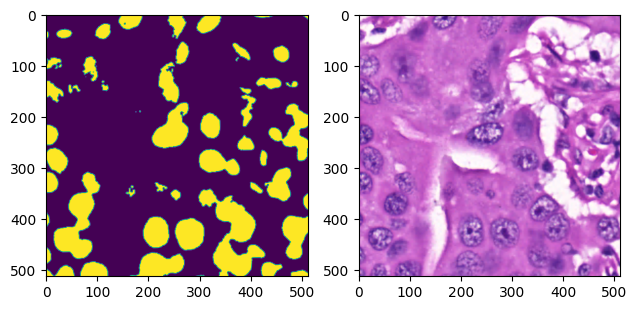

In [3]:
dapi_transform_old_method = cv2.warpAffine(dapi_raw_data, inverse_matrix, he.shape[0:2])

plt.subplot(1, 2, 1)
plt.imshow(dapi_transform_old_method[2048:2048+512, 2048:2048+512])

plt.subplot(1, 2, 2)
plt.imshow(he[2048:2048+512, 2048:2048+512])

plt.tight_layout()

New method: Instead of transforming the entire image, take a region from the H&E image, transform the coordinates and plot the transformed region of the second image

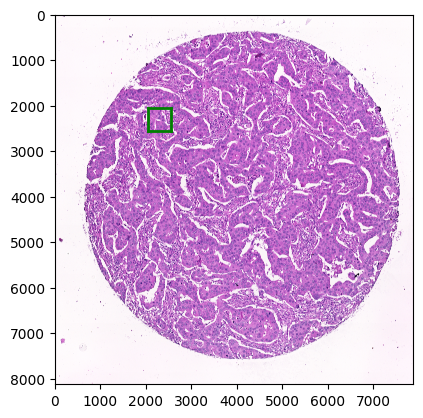

In [4]:
bbox_coords_image1 = np.array([[2048, 2048], [2560, 2048], [2560, 2560], [2048, 2560]], dtype=np.int32)

# Draw coordinate polygons on the image to show region
plt.imshow(he)
for i in range(len(bbox_coords_image1)):
    x1, y1 = bbox_coords_image1[i]
    x2, y2 = bbox_coords_image1[(i + 1) % len(bbox_coords_image1)]
    plt.plot([x1, x2], [y1, y2], color='green', linewidth=2)
plt.show()

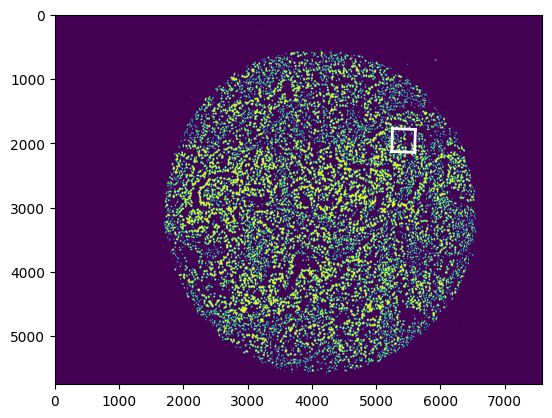

In [5]:
# Transform the polygon coordinates to new coordinates for CODEX
codex_coords = cv2.transform(np.array([bbox_coords_image1]), transform_matrix)[0]


print(codex_coords)
# Draw coordinate polygons on the image to show region
plt.imshow(dapi_raw_data)
for i in range(len(codex_coords)):
    x1, y1 = codex_coords[i]
    x2, y2 = codex_coords[(i + 1) % len(codex_coords)]
    plt.plot([x1, x2], [y1, y2], color='white', linewidth=2)
plt.show()

The polygons seem to overlap pretty well according to the coordinate transform. Now the plan is to somehow make this region extractable

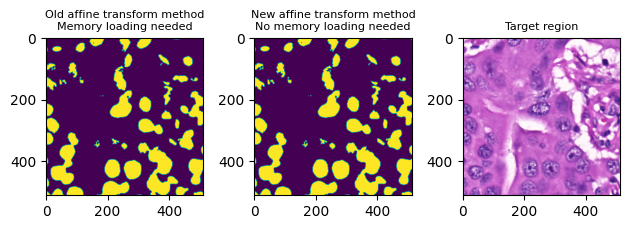

In [6]:
codex_coords = np.array(codex_coords, dtype=np.float32)

target_square_size = 512
target_coords = np.array([[0, 0], [target_square_size, 0], [target_square_size, target_square_size], [0, target_square_size]], dtype=np.float32)

perspective_matrix = cv2.getPerspectiveTransform(codex_coords, target_coords)

warped_image = cv2.warpPerspective(dapi_raw_data, perspective_matrix, (target_square_size, target_square_size))

plt.subplot(1, 3, 1)
plt.imshow(dapi_transform_old_method[2048:2048+512, 2048:2048+512])
plt.title("Old affine transform method\nMemory loading needed", fontsize=8)

plt.subplot(1, 3, 2)
plt.imshow(warped_image)
plt.title("New affine transform method\nNo memory loading needed", fontsize=8)

plt.subplot(1, 3, 3)
plt.imshow(he[2048:2048+512, 2048:2048+512])
plt.title("Target region", fontsize=8)

plt.tight_layout()

plt.show()

